In [0]:
# Before executing this bash cell you need to upload all the zip files 
# gracefully prepared by me into the /content directory.
# Then execute this cell.
# It'll create a data/train relative directory and unzip the uploaded files.

%%shell
rm -r /content/data/
mkdir -p /content/data/train

for i in {0..11}
do
  unzip "/content/train$i.zip" -d /content/data/train
  unzip "/content/train0$i.zip" -d /content/data/train
done

In [0]:
import pandas as pd
from glob import glob
import os
from PIL import Image
import numpy as np
import random

In [3]:
%tensorflow_version 1.x

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

random.seed(34)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# Скачайте полные данные отсюда https://www.kaggle.com/c/dogs-vs-cats/data (примерно 820мб)
# У вас должно быть две папки train и test. Однако в данном задании мы не будем использвать test выборку
# Функцию для чтения данных мы реализовали за вас

def read_dataset(path):
    X = []
    y = []
    
    image_paths_list = glob(os.path.join(path, 'train', '*.jpg'))
    image_paths_sample = random.sample(image_paths_list, 10000)

    for image_path in image_paths_sample:
        image_name = os.path.basename(image_path)
        image_name_parts = image_name.split('.')
        label = image_name_parts[0] if len(image_name_parts) == 3 else None

        if label:
            y.append(int(label == 'cat'))
            
        
        x = image.img_to_array(image.load_img(image_path, target_size=(224, 224)))
        x = preprocess_input(x)
            
        X.append(x)
            
    return np.array(X), np.array(y)

Перепишите код read_dataset() таким образом чтобы читать изображения пачками по 1000 и сразу применять предобученный ResNet на них, сохраняя только полученные вектора как множество X. Примените эту функцию на всём датасете 25000 изображений.

In [0]:
from tqdm import tqdm_notebook

train_directory = "data/"
batch_size = 1000
images_number = 10000

def read_dataset(path):
    """ X should be numpy array from the start. Otherwise it takes too much memory.
    """

    X = np.array([])
    y = np.array([])
    
    image_paths_list = glob(os.path.join(path, 'train', '*.jpg'))
    image_paths_list = random.sample(image_paths_list, images_number)
    
    np.random.shuffle(image_paths_list)
    
    # split into array of batch_size length arrays
    splitted_image_paths_list = np.split(np.array(image_paths_list), int(len(image_paths_list) / batch_size))
    
    for image_path_batch in tqdm_notebook(splitted_image_paths_list, desc='Batches'):
        x_batch = []
        y_batch = []
        
        for image_path in tqdm_notebook(image_path_batch, desc='Current batch', leave=False):
            image_name = os.path.basename(image_path)
            image_name_parts = image_name.split('.')
            label = image_name_parts[0] if len(image_name_parts) == 3 else None
            
            if label:
                y_batch.append(int(label == 'cat'))
            
            x = image.img_to_array(image.load_img(image_path, target_size=(224, 224)))#, dtype=np.uint8)

            '''if x_batch.size == 0:
              x_batch = x[None,:,:,:]
            else:
              x_batch = np.concatenate([x_batch, x[None,:,:,:]], axis=0)'''
            x_batch.append(x)
        

        x_batch = preprocess_input(np.array(x_batch))
        y_batch = np.array(y_batch)
        
        if X.size == 0:
          X = x_batch
          y = y_batch
        else:
          X = np.concatenate([X, x_batch], axis=0)
          y = np.concatenate([y, y_batch], axis=0)
    
    return X, y

In [6]:
# Используйте функцию read_dataset чтобы получить обучающую выборку
features, labels = read_dataset("/content/data")

# Проверьте размерности загруженных данных
print(features.shape)
print(labels.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(10000, 224, 224, 3)
(10000,)


In [7]:
# с помощью функции train_test_split поделите выборку на train и test в отношении 70/30
# В качестве признаков используйте эмбеддинги, полученные на предыдущем шаге
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3)
print(features_train.shape)
print(labels_train.shape)
print(features_test.shape)
print(labels_test.shape)

(7000, 224, 224, 3)
(7000,)
(3000, 224, 224, 3)
(3000,)


In [8]:
# Создаём модель для получения эмбеддингов
model = ResNet50(weights='imagenet')

# Используя объект model постройте эмбеддинги для обучающей выборки
%time embeddings_train = model.predict(features_train)
%time embeddings_test = model.predict(features_test)














CPU times: user 1h 1min 48s, sys: 25.1 s, total: 1h 2min 13s
Wall time: 15min 52s
CPU times: user 26min 13s, sys: 11.5 s, total: 26min 24s
Wall time: 6min 43s


Попытка классифицировать свою кошку с помощью ResNet.

In [9]:
!unzip /content/jerry.zip -d /content/data/my-pet

Archive:  /content/jerry.zip
  inflating: /content/data/my-pet/20200313_174746.jpg  
  inflating: /content/data/my-pet/20200313_174805.jpg  
  inflating: /content/data/my-pet/20200313_174817.jpg  
  inflating: /content/data/my-pet/20200313_174831.jpg  
  inflating: /content/data/my-pet/20200313_174847.jpg  
  inflating: /content/data/my-pet/20200313_174849.jpg  
  inflating: /content/data/my-pet/20200313_174933.jpg  
  inflating: /content/data/my-pet/20200313_174954.jpg  
  inflating: /content/data/my-pet/20200313_174956.jpg  
  inflating: /content/data/my-pet/20200313_175017.jpg  
  inflating: /content/data/my-pet/20200313_175025.jpg  
  inflating: /content/data/my-pet/20200313_175027.jpg  
  inflating: /content/data/my-pet/20200316_231721.jpg  
  inflating: /content/data/my-pet/20200317_102327.jpg  
  inflating: /content/data/my-pet/20200317_102330.jpg  
  inflating: /content/data/my-pet/20200317_102344.jpg  


In [10]:
# check my own pet photos
def read_my_pet_dataset(path):
    X = []
    
    image_paths_list = glob(os.path.join(path, 'my-pet', '*.jpg'))

    for image_path in image_paths_list:
        image_name = os.path.basename(image_path)        
        x = image.img_to_array(image.load_img(image_path, target_size=(224, 224)))
        x = preprocess_input(x)
            
        X.append(x)
            
    return np.array(X)


pet_features = read_my_pet_dataset("data/")
print(pet_features.shape)

pet_embeddings = model.predict(pet_features)
print(decode_predictions(pet_embeddings, top=1))

(16, 224, 224, 3)
[[('n02441942', 'weasel', 0.4639576)], [('n02123394', 'Persian_cat', 0.58622897)], [('n02093647', 'Bedlington_terrier', 0.05776652)], [('n01877812', 'wallaby', 0.16427185)], [('n01622779', 'great_grey_owl', 0.3220467)], [('n02102973', 'Irish_water_spaniel', 0.12897159)], [('n02441942', 'weasel', 0.25759768)], [('n02127052', 'lynx', 0.24749047)], [('n02123394', 'Persian_cat', 0.31379968)], [('n02127052', 'lynx', 0.27399546)], [('n04399382', 'teddy', 0.16075166)], [('n02123394', 'Persian_cat', 0.3944722)], [('n02497673', 'Madagascar_cat', 0.21311994)], [('n02127052', 'lynx', 0.41493312)], [('n02113624', 'toy_poodle', 0.7856534)], [('n02123394', 'Persian_cat', 0.28453523)]]


Создайте объект XGBClassifier со стандартными параметрами

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

Обучите его

In [0]:
# Получите предсказания на тестовом и на обучающем множестве
clf = XGBClassifier()

clf.fit(embeddings_train, labels_train)
predicted_test = clf.predict(embeddings_test)

In [12]:
# С помощью функции accuracy_score оцените результаты
print(accuracy_score(labels_test, predicted_test))

0.983


Trying XGBoost to predict whether my pet is cat or dog:

In [13]:
my_cat_predictions = clf.predict(pet_embeddings)

# there's always a cat in the pictures of my pet
my_cat_labels = np.ones(pet_features.shape[0])
print(accuracy_score(my_cat_labels, my_cat_predictions))

1.0


Почитайте про параметры XGBoost здесь: https://sites.google.com/view/lauraepp/parameters
Сделайте тюнинг гиперпараметров для XGBoost:
1. Подберите максимальный num_iterations при котором скор на валидации близок к максимальному, а скорость обучения ещё приемлимая
2. Для заданного num_iterations подберите подходящий learning rate
3. С помощью библиотеки hyperopt подберите остальные гиперпараметры при фиксимрованных num_iterations и learning_rate. Не подбирайте параметр early_stopping

CPU times: user 2min 23s, sys: 22.3 ms, total: 2min 23s
Wall time: 2min 23s

Accuracy: 0.9773333333333334


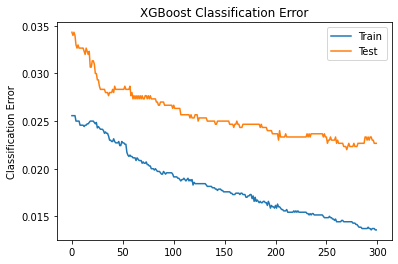

In [16]:
tuned_clf = XGBClassifier(n_estimators=300, learning_rate=0.01)

eval_set = [(embeddings_train, labels_train), (embeddings_test, labels_test)]


%time tuned_clf.fit(embeddings_train, labels_train, eval_set=eval_set, verbose=False)
tuned_test = tuned_clf.predict(embeddings_test)
print("\nAccuracy:", accuracy_score(labels_test, tuned_test))


from matplotlib import pyplot as plt

results = tuned_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

Оцените важность признаков с помощью поля feature_importances_

Пользуясь списком https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a посмотрите, какие классы оказались наиболее важными (со значениями importance больше 0)
    
Изменяйте параметры, чтобы оставить только действительно важные признаки

In [15]:
all_important_features_indices = np.where(tuned_clf.feature_importances_ > 0)
print('All non-zero importance classes: ', all_important_features_indices)

top_ten_features = np.argpartition(tuned_clf.feature_importances_, -10)[-10:]
print('Top 10 important features indices: ', top_ten_features)
print('Importance of top 10 features: ',tuned_clf.feature_importances_[top_ten_features])

All non-zero importance classes:  (array([  5,  30,  34,  50,  58,  97, 112, 152, 159, 161, 164, 166, 167,
       172, 174, 176, 177, 179, 180, 182, 194, 200, 204, 207, 209, 210,
       212, 215, 220, 222, 223, 225, 227, 234, 236, 238, 243, 244, 248,
       252, 259, 260, 263, 264, 265, 267, 269, 270, 273, 276, 281, 282,
       283, 284, 285, 293, 304, 316, 332, 346, 361, 375, 379, 383, 415,
       453, 455, 458, 489, 532, 537, 556, 584, 676, 705, 717, 785, 805,
       824, 839, 852, 961, 977, 997]),)
Top 10 important features indices:  [180 159 200 284 282 283 234 332 285 281]
Importance of top 10 features:  [0.01212971 0.01505106 0.01272017 0.01687917 0.06896176 0.02602317
 0.01709845 0.02336935 0.13703127 0.344372  ]
